### Настройка среды

In [1]:
import os
import sys

sys.path.append(os.path.abspath(".."))

In [2]:
%pip install belashovplot

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from elements.modulators import Lens, PhaseModulator
from elements.propagators import FurrierPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt
import torch

### Цель эксперемента

Целью данного эксперемента является задание системы ...

### Настройка некогерентности

In [4]:
spatial_coherence = 50.0E-6
time_coherence = 10.0E-9
time_relaxation = 1.0E-6
mean_samples = 20 #100

print(f"Временная когерентность:        {engineering(time_coherence, 'с')}")
print(f"Время релаксации:               {engineering(time_relaxation, 'c')}")
print(f"Пространственная когерентность: {engineering(spatial_coherence, 'м')}")

Временная когерентность:        10.0 нс
Время релаксации:               1.0 мкc
Пространственная когерентность: 50.0 мкм


## Система без линз

Описание системы

### Настройка параметров системы

In [5]:
length = 3.0E-3
wavelength = 500E-9
mask_unit_length = 20.0E-6
masks_amount = 5
cppp = 2

pixels = int(length/mask_unit_length) + 1
N = int(pixels*cppp)
distance = length * sqrt((mask_unit_length/wavelength)**2-1) * 1.0

print(f"Длинна волны:                             {engineering(wavelength, 'м')}")
print(f"Количество вычислительных пикселей:       {N}")
print(f"Количество пикселей маски:                {pixels}")
print(f"Количество модуляторов:                   {masks_amount}")
print(f"Размер оптических элементов:              {engineering(length, 'м')}")
print(f"Размер пикселя маски:                     {engineering(mask_unit_length, 'м')}")
print(f"Расстояние между слоями:                  {engineering(distance, 'м')}")

Длинна волны:                             500.0 нм
Количество вычислительных пикселей:       302
Количество пикселей маски:                151
Количество модуляторов:                   5
Размер оптических элементов:              3.0 мм
Размер пикселя маски:                     20.0 мкм
Расстояние между слоями:                  119.962 мм


### Отрисовка некогерентности

0.001120091648772359 0.48211465664062503
0.0002448921441100538 2.1647153622257313e-12
0.0007672904175706208 2.67172096917541e-12
0.0008822658564895391 1.6487370722477577e-12
0.0018081667367368937 8.243685361238788e-13
Parameter containing:
tensor([0.1416, 0.4359, 1.0159, 1.0163], device='cuda:0')


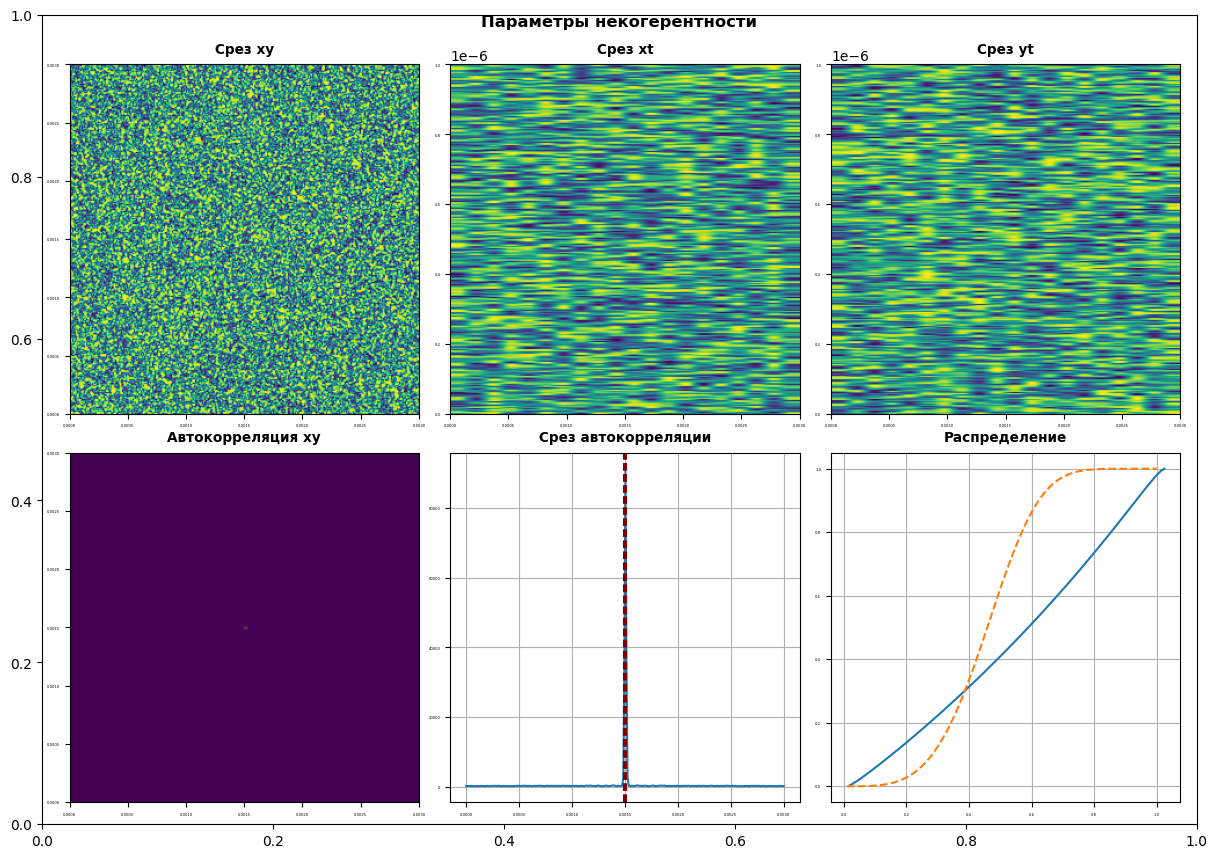

In [6]:
incoherent = Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length)
incoherent = incoherent.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
incoherent.delayed.launch()
incoherent.show()

### Инициализация оптической модели

In [7]:
propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance, 0.7)
modulators = [PhaseModulator(N, length, pixels) for i in range(masks_amount)]
elements = [modulators[0]]
for modulator in modulators[1:]:
    elements.append(propagation)
    elements.append(modulator)
elements.append(propagation)

chunker = CudaMemoryChunker(10)

optical = CompositeModel(*elements)
optical.wrap(chunker)
optical.wrap(incoherent)
optical.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

CompositeModel(
  (Element0): PhaseModulator()
  (Element1): FurrierPropagation()
  (Element2): PhaseModulator()
  (Element3): FurrierPropagation()
  (Element4): PhaseModulator()
  (Element5): FurrierPropagation()
  (Element6): PhaseModulator()
  (Element7): FurrierPropagation()
  (Element8): PhaseModulator()
  (Element9): FurrierPropagation()
  (Wrapper0): CudaMemoryChunker()
  (Wrapper1): Incoherent(
    (_generator): GaussianNormalizer(
      (_generator): FourierMask()
    )
  )
)

### Инициализация детекторов

In [8]:
detectors_amount = 20

spectral_filter = Window(centers=wavelength, sizes=300.0E-9)
detectors_filter = Gaussian((length/30, length/30), (0,0))
detectors = ClassificationDetectors(N, length, wavelength, detectors_amount, detectors_filter, spectral_filter)
detectors.to(optical.device)

ClassificationDetectors()

### Инициализация электронной модели

In [9]:
layers_structure = [detectors_amount, detectors_amount, 15, 10]

layers = []
for nodes0, nodes1 in zip(layers_structure[:-1], layers_structure[1:]):
    layers.append(torch.nn.Linear(nodes0, nodes1))
    layers.append(torch.nn.Sigmoid())
electronic = torch.nn.Sequential(*layers)
electronic.to(optical.device)

Sequential(
  (0): Linear(in_features=20, out_features=20, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=20, out_features=15, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=15, out_features=10, bias=True)
  (5): Sigmoid()
)

### Инициализация гибридной модели

In [10]:
image, _ = Dataset.single('STL10', N, N, torch.complex64)
image = image.to(optical.device)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 10/10 [00:00<00:00, 79.36it/s]


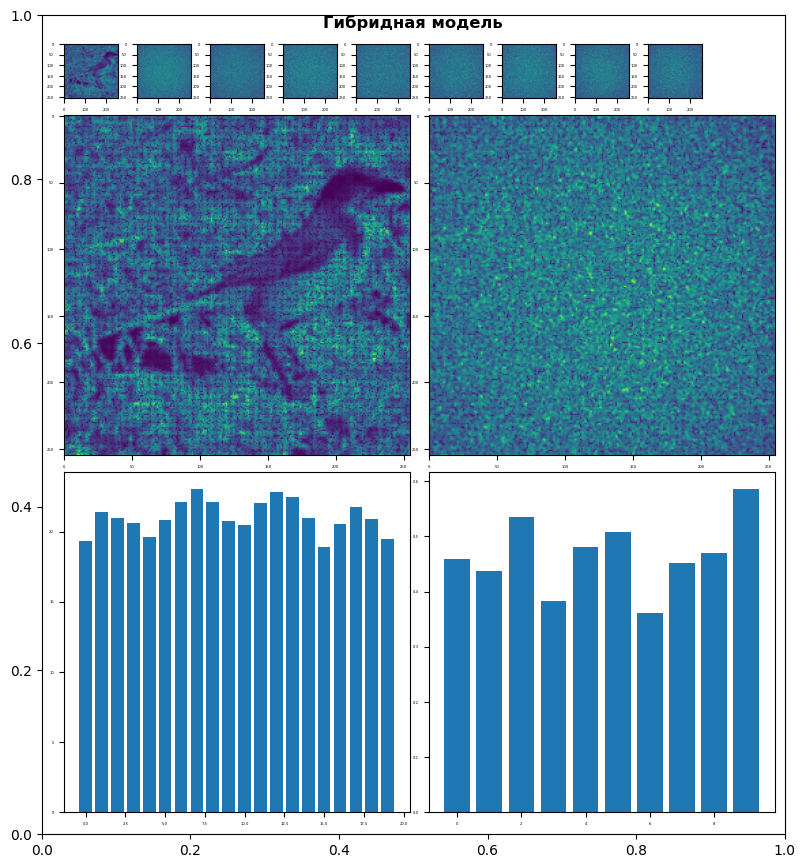

In [11]:
model = HybridModel(optical, detectors, electronic)
model.visualize(image)

### Инициализация набора данных

In [12]:
dataset = Dataset('STL10', 50, N, N, torch.complex64)
dataset.train
dataset.test

Files already downloaded and verified
Files already downloaded and verified


### Инициализация лосс функции и обучающего модуля

In [20]:
CrossEntropy = torch.nn.CrossEntropyLoss()
def loss_function(results:torch.Tensor, labels0:torch.Tensor):
    labels = torch.softmax(results, dim=1)
    return CrossEntropy(labels, labels0)

optical_optimizer = torch.optim.Adam(model._optical_model.parameters(), lr=0.001)
electronic_optimizer = torch.optim.Adam(model._electronic_model.parameters(), lr=0.001)

def epoch():
    torch.cuda.empty_cache()
    history = []
    iterator = tqdm(dataset.train)
    for images, labels in iterator:
        optical_optimizer.zero_grad()
        electronic_optimizer.zero_grad()
        
        labels = labels.to(model.device)
        results = []
        for image in images:
            image = image.unsqueeze(0).to(model.device)
            image = model.forward(image)
            results.append(image[0])
            image = image.to(torch.device('cpu'))
        
        loss = loss_function(torch.stack(results, dim=0), labels)
        loss.backward()
        electronic_optimizer.step()
        optical_optimizer.step()
        
        history.append(loss.item())
        iterator.set_description(f"Loss: {loss.item()}")
        iterator.refresh()
    return history

## Обучение модели

### Эпоха №1

In [21]:
history1 = []
history1 += epoch()
history1 += epoch()
history1 += epoch()
history1 += epoch()

Loss: 2.3019845485687256: 100%|██████████| 100/100 [03:42<00:00,  2.23s/it]


100%|██████████| 10/10 [00:00<00:00, 84.65it/s]


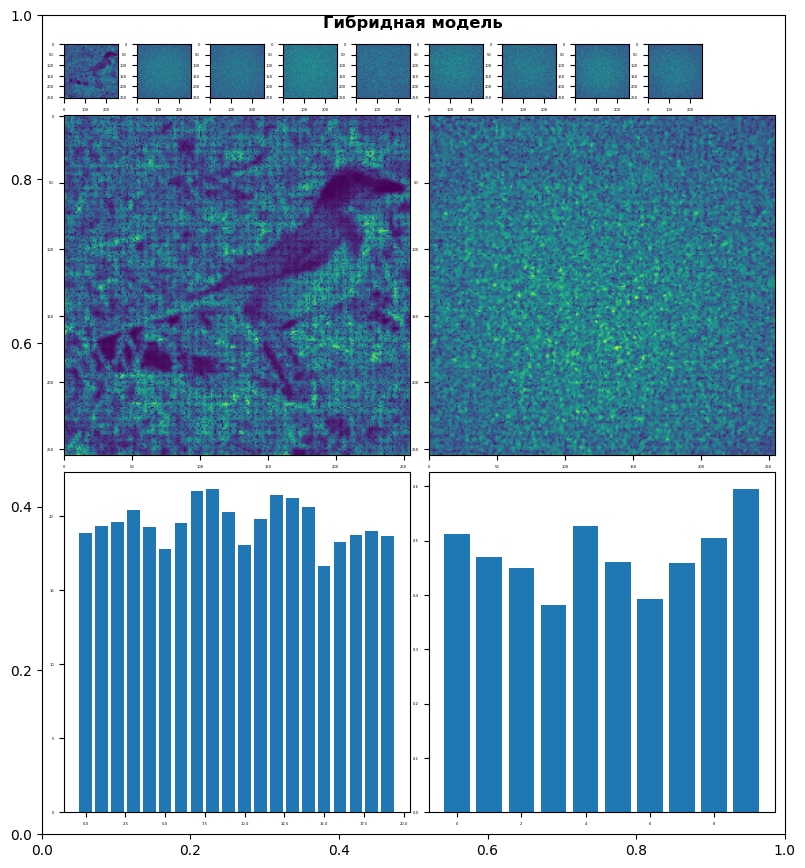

In [22]:
model.visualize(image)

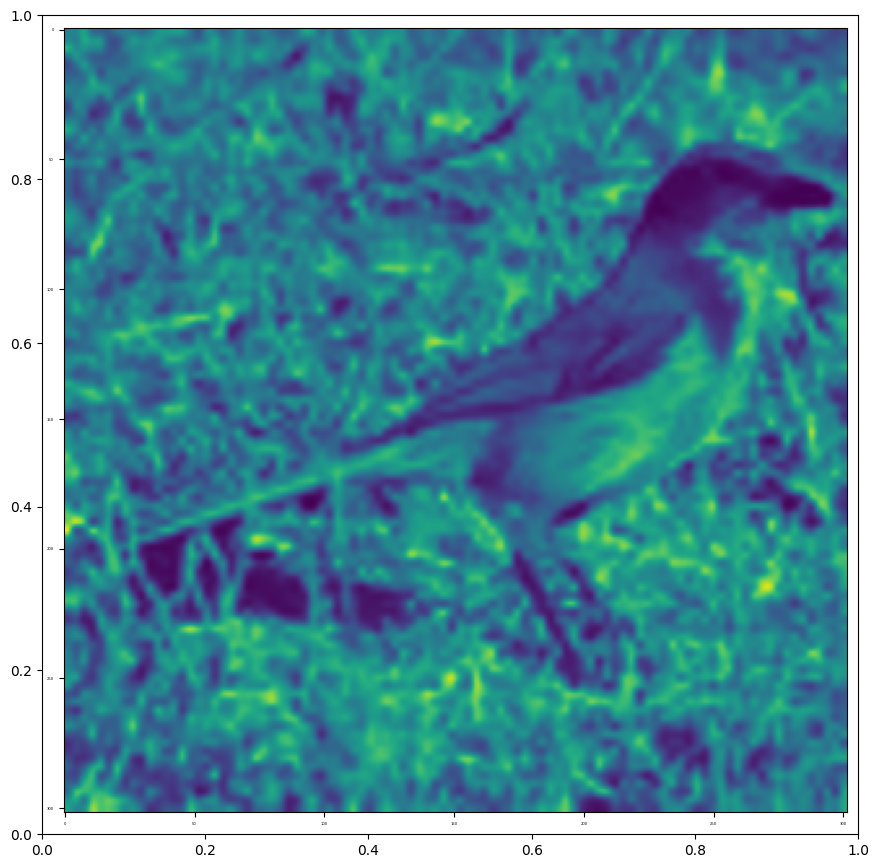

In [28]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.axes.add(0,0).imshow(image.cpu().abs()[0][0]**2)
plot.show()